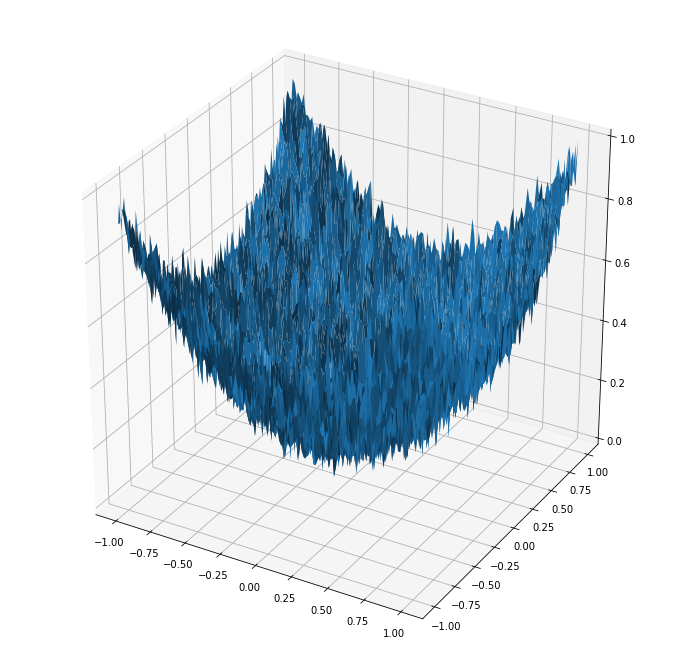

In [4]:
import time

from typing import Callable, Dict, Tuple
from collections import namedtuple

import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
n = 128
x = y = np.linspace(-1, 1, n)
x , y = np.meshgrid (x, y)
g = x**2 + y**2 + 0.1 * np.random.randn(*x.shape)
g = (g - g.min()) / (g.max() - g.min())
ax.plot_surface(x, y, g)

## Wood y la otra

In [0]:
def f2(x :np.array, n :int=100) -> float:
    """ Compute the evaluation for Extended Rosembrock function with n=100
        Args:
        x: Array of length=n with x's parameters
        n: Rosembrock, n = 100
        
        Returns:
            Evaluation of f(X)
    """
    ans = 0.0
    for i in range(n-1):
        ans += 100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2
    return ans


def f2_grad(x :np.array, n :int=100) -> np.array:
    """ Compute the gradient evaluation for Extended Rosembrock function with n=2 
        Args:
        x: Array of length=n with x's parameters
        n: Rosembrock, n = 100
        
        Returns:
            Gradient of f(x1, ..., xn), array with lenght=n
    """
    # grad = np.zeros(n, dtype=np.float64)
    # for i in range(n-1):
    #     grad[i] = -400 * x[i+1] * x[i] + 400 * x[i]**3 + 2 * x[i] -2
    # grad[n-1] = 200 * (x[n-1] - x[n-2]**2)
    # return grad
    grad=np.array([-400*(x[1]-x[0]**2)*x[0]-2*(1-x[0])])
    
    for i in range(1, n-1): 
        grad=np.append(grad,[200*(x[i]-x[i-1]**2)-400*(x[i+1]-x[i]**2)*x[i]-2*(1-x[i])])
    
    grad=np.append(grad,[200*(x[99] - x[98]**2)])
    
    return grad


def f2_hess(x :np.array, n :int=100) -> np.array:
    """ Compute the Hessian evaluation for Extended Rosembrock function with n=2 
        Args:
        x: Array of length=n with x's parameters
        
        Returns:
            Hessian of f(x1, ..., xn), Matrix with size=nxn
    """
    hess = np.zeros((n, n), dtype=np.float64)
    for i in range(n-1):
            hess[i][i] = -400 * x[i+1] + 1200 * x[i]**2 + 2
            hess[i][i] += 200 if i != 0 else 0
            hess[i][i+1] = hess[i+1][i] = -400 * x[i]
    hess[n-1][n-1] = 200.0
    return hess



In [0]:
def f3(x :np.array) -> float:
    """ Compute the evaluation for Wood Function function with n=100
        Args:
        x: Array of length=4 with x's parameters
        
        Returns:
            Evaluation of f(X)
    """
    f1 = 100*(x[0]**2 - x[1])**2 + (x[0]-1)**2 + 10.1*(x[1]-1)**2 + (x[2]-1)**2 
    f2 = 10.1*(x[3]-1)**2 + 90*(x[2]**2-x[3])**2 +19.8*(x[1]-1)*(x[3]-1)
    return f1 + f2
    # ans = 100 * (x[0]**2 - x[1]) + (x[0] - 1)**2 + (x[2] - 1)**2 + 90 * (x[2]**2 - x[3])**2
    # ans += 10.1 * ((x[1] - 1)**2 + (x[3] - 1)**2) + 19.8 * (x[1] - 1) * (x[3] - 1)
    # return ans


def f3_grad(x :np.array) -> np.array:
    """ Compute the gradient evaluation for Extended Rosembrock function with n=2 
        Args:
        x: Array of length=4 with x's parameters
        
        Returns:
            Gradient of f(x1, x2, x3, x4), array with lenght=4
    """
    grad = np.zeros(4, dtype=np.float64)
    grad[0] = 400 * x[0]**3 - 400 * x[0] * x[1] + 2 * x[0] - 2
    grad[1] = -200 * (x[0]**2 - x[1]) + 20.2 * (x[1] - 1) + 19.8 * x[3] - 19.8
    grad[2] = 2 * x[2] - 2 + 360 * x[2]**3 - 360 * x[3] * x[2]
    grad[3] = -180 * (x[2]**2 - x[3]) + 20.2 * (x[3] - 1) + 19.8 * (x[1] -1)
    return grad


def f3_hess(x :np.array) -> np.array:
    """ Compute the Hessian evaluation for Extended Rosembrock function with n=2 
        Args:
        x: Array of length=4 with x's parameters
        
        Returns:
            Hessian of f(x1, x2, x3, x4), Matrix with size=4x4
    """
    hess = np.zeros((4, 4), dtype=np.float64)
    
    hess[0][0] = 1200 * x[0]**2 - 400 * x[1] + 2
    hess[0][1] = hess[1][0] = -400 * x[0]
    hess[1][1] = 220.2
    hess[2][2] = 1080 * x[2]**2 - 360 * x[3] + 2
    hess[3][1] = hess[1][3] = 19.8
    hess[3][2] = hess[2][3] = -360 * x[2]
    hess[3][3] = 200.2
    
    return hess

## Gradiente Conjugado

In [0]:
def gc(X: np.array,
       f: Callable[[np.array], np.array],
       g: Callable[[np.array], np.array],
       tol_g: float=1e-12,
       mxitr: int=1000,
       **kwargs):
    Result = namedtuple('Result', 'x_log f_log g_norm_log')

    # Logs 
    x_log = []
    f_log = []
    g_norm_log = []

    # x_k
    x_k = X
    x_k_next = None
    x_log.append(x_k)

    # f_k
    f_k = f(x_k, **kwargs.get('f_kwargs', {}))
    f_log.append(f_k)

    # g_k
    g_k = g(x_k, **kwargs.get('g_kwargs', {}))
    g_k_next = None
    g_norm_log.append(np.linalg.norm(g_k))

    #
    # Q = kwargs.get('Q')
    d_k = -g_k
    gg_k = g_k.dot(g_k)
    
    H = kwargs['H']

    k = 0
    while g_norm_log[-1] > tol_g and k < mxitr:
        Q = H(x_k, **kwargs.get('H_kwargs', {}))
        
        # q_k = Q @ d_k
        
        # alpha_k = gg_k / (d_k.dot(q_k))
        alpha_k = - (g_k.dot(d_k)) / (d_k @ Q @ d_k)
        
        x_k = x_k + alpha_k * d_k
        x_log.append(x_k)
        
        # g_k = g_k + alpha_k * q_k
        g_k = g(x_k, **kwargs.get('g_kwargs', {}))
        g_norm_log.append(np.linalg.norm(g_k))
        
        # gg_kn = g_k.dot(g_k)
        # beta_k = gg_kn / gg_k
        beta_k = (g_k @ Q @ d_k) / (d_k @ Q @ d_k)
        # gg_k = gg_kn
        
        d_k = -g_k + beta_k * d_k

        f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))
        k += 1


    return Result(x_log, f_log, g_norm_log)


iters: 713
g norm 8.373156137542050381e-13
f error 3.9866238543009337421


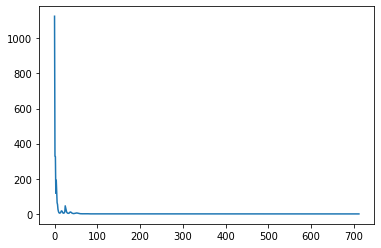

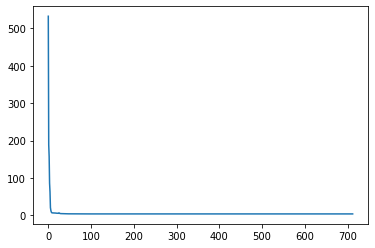

array([-0.9932861 ,  0.99665107,  0.99833032,  0.99916774,  0.9995852 ,
        0.99979328,  0.99989698,  0.99994866,  0.99997441,  0.99998725,
        0.99999365,  0.99999683,  0.99999842,  0.99999921,  0.99999961,
        0.9999998 ,  0.9999999 ,  0.99999995,  0.99999998,  0.99999999,
        0.99999999,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.  

In [81]:
X = np.ones(100, dtype=np.float128)
X[0] = X[-2] = -1.2

# X = np.random.rand(100)

xop = np.ones(100)

params = {
    'X': X,
    'f': f2,
    'g': f2_grad,
    'H': f2_hess,
    'tol_x': 1e-12,
    'tol_f': 1e-12,
    'tol_g': 1e-12,
    'mxitr': 10000,
    'delta': 0.1,
    'delta_max': 0.2,
    'eta': 0.1,
    'Q': f2_hess(X)
}

ans = gc(**params)

print("iters: %d" % len(ans.x_log))
print("g norm", ans.g_norm_log[-1])
print("f error", ans.f_log[-1] - f2(xop))

plt.plot(ans.g_norm_log)
plt.show()
plt.plot(ans.f_log)
plt.show()
ans.x_log[-1]

iters: 10001
g norm 2.0
f error 4.9123908920863337786e-36


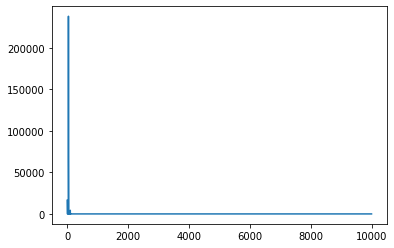

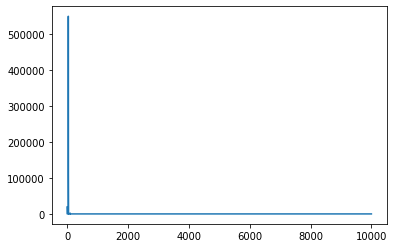

array([1., 1., 1., 1.], dtype=float128)

In [79]:
X = np.array([-3, -1, -3, -1], dtype=np.float128)
xop = np.ones(4)

params = {
    'X': X,
    'f': f3,
    'g': f3_grad,
    'H': f3_hess,
    'tol_g': 1e-20,
    'mxitr': 10000,
    'alpha': 1e-2,
    'delta': 0.01,
    'delta_max': 1,
    'eta': 0.01,
    'Q': f3_hess(X)
}

ans = gc(**params)

print("iters: %d" % len(ans.x_log))
print("g norm", np.linalg.norm(ans.x_log[-1]))
print("f error", ans.f_log[-1] - f3(xop))

plt.plot(ans.g_norm_log)
plt.show()
plt.plot(ans.f_log)
plt.show()
ans.x_log[-1]